<a href="https://colab.research.google.com/github/jdeepanshu/loan-msme/blob/main/loan_msme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
%matplotlib inline
#Seting option for full column view of Data
pd.set_option('display.max_columns', None)

##Reading Data

In [2]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv")
display(df.head())
df.shape


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


(396030, 27)

##Helper Functions

In [3]:
#missing Values
def find_missing_values(df, all_columns=True):
    total_rows = len(df)
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / total_rows) * 100

    if all_columns:
        result_df = pd.DataFrame({
            'Column ': missing_percentage.index,
            'Count': missing_data.values,
            'Percentage': missing_percentage.values.round(2)
        })
    else:
        missing_mask = missing_percentage > 0
        result_df = pd.DataFrame({
            'Column': missing_percentage.index[missing_mask],
            'Count': missing_data.values[missing_mask],
            'Percentage': missing_percentage.values[missing_mask].round(2)
        })

    return result_df.sort_values(by='Percentage', ascending=False)


##Data info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [5]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.89,8357.44,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.64,4.47,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.85,250.73,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.18,61637.62,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.38,18.02,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.31,5.14,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.18,0.53,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.54,20591.84,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.79,24.45,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.41,11.89,2.00,17.00,24.00,32.00,151.00


In [6]:
df.describe(include="object").T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


In [7]:
##Checking Duplicate Rows
duplicate_rows = df.duplicated()
duplicate_rows.sum()

0

##Extracting Data

In [8]:
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df['term'].map(term_values)

In [9]:
#Address
df["address"][:5]

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [10]:
df['postal_code'] = df['address'].str.split().apply(lambda x: x[-1])
df['State'] = df['address'].str.split().apply(lambda x: x[-2])
df['City'] = df['address'].str.split().apply(lambda x: x[-3])
df=df.drop(["address"],axis = 1)

In [11]:
find_missing_values(df,False)

,Column,Count,Percentage
4,mort_acc,37795,9.54
0,emp_title,22927,5.79
1,emp_length,18301,4.62
2,title,1755,0.44
5,pub_rec_bankruptcies,535,0.14
3,revol_util,276,0.07


##EDA

In [12]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

In [13]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'postal_code',
 'State',
 'City']

In [14]:
#### Loan amount

In [15]:
df.groupby(by = "loan_status")['loan_amnt'].describe().round(2).T

loan_status,Charged Off,Fully Paid
count,77673.00,318357.00
mean,15126.30,13866.88
std,8505.09,8302.32
min,1000.00,500.00
25%,8525.00,7500.00
50%,14000.00,12000.00
75%,20000.00,19225.00
max,40000.00,40000.00


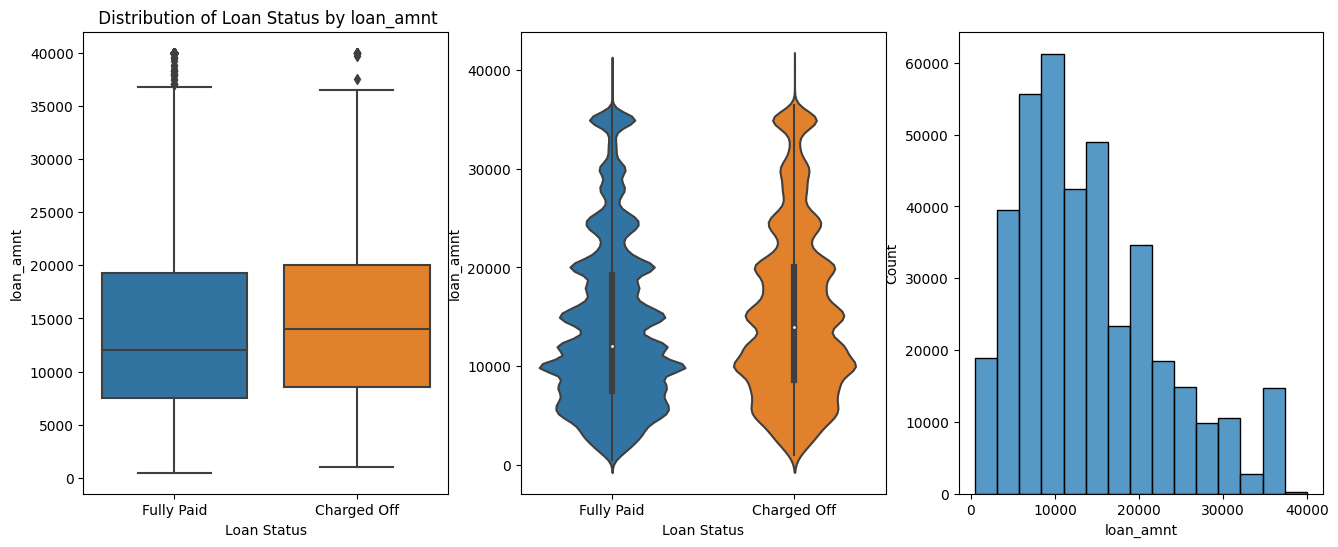

In [16]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
item="loan_amnt"
sns.boxplot(data=df, x="loan_status", y=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)


sns.violinplot(data=df, x="loan_status", y=item, ax=axes[1])
# axes[1].set_title(" Distribution of Loan Status by "+ item )
axes[1].set_xlabel("Loan Status")
axes[1].set_ylabel(item)

sns.histplot(df["loan_amnt"],bins = 15, ax=axes[2])

# plt.title("Loan Status by "+ item )
plt.show()

In [17]:
#### Loan Term


In [18]:
(pd.crosstab(index=df["term"],
            columns=df["loan_status"], normalize="index" , margins  = True
           ) * 100).round(2)

loan_status,Charged Off,Fully Paid
term,,
36,15.77,84.23
60,31.94,68.06
All,19.61,80.39


<Axes: xlabel='term'>

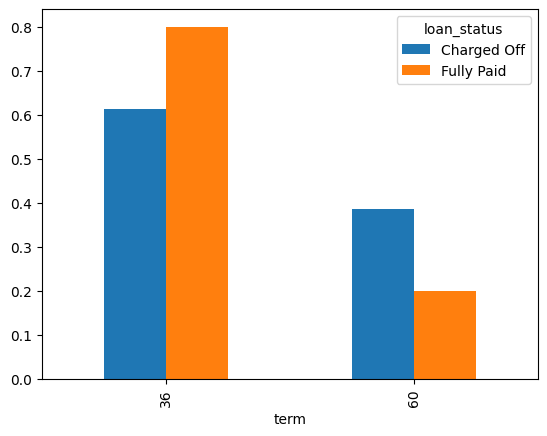

In [19]:
pd.crosstab(index=df['term'],
            columns =df["loan_status"], normalize="columns"
           ).plot(kind = "bar")

In [20]:
### Int Rate

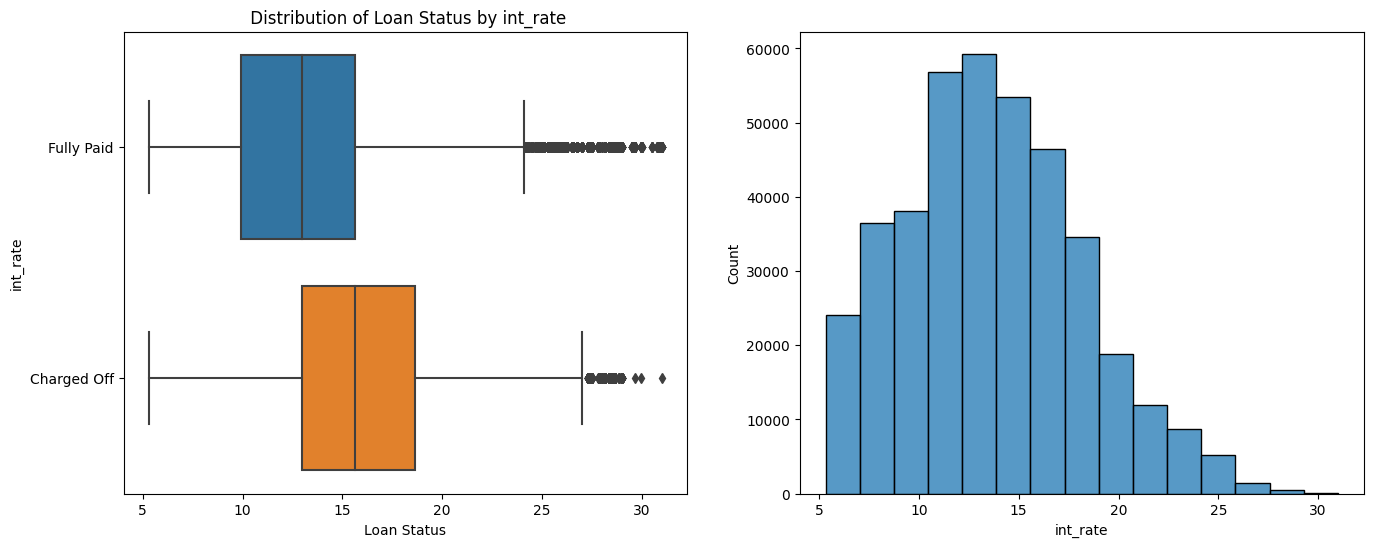

In [21]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="int_rate"
sns.boxplot(data=df, y="loan_status", x=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)


sns.histplot(df["int_rate"],bins = 15, ax=axes[1])

# plt.title("Loan Status by "+ item )
plt.show()

In [22]:
df[df["loan_status"] == "Charged Off"]["int_rate"].median(),df[df["loan_status"] == "Charged Off"]["int_rate"].mean().round(2)

(15.61, 15.88)

In [23]:
df[df["loan_status"] == "Fully Paid"]["int_rate"].median(),df[df["loan_status"] == "Fully Paid"]["int_rate"].mean().round(2)

(12.99, 13.09)

### Emp Title

### Emp Length

<Axes: xlabel='emp_length'>

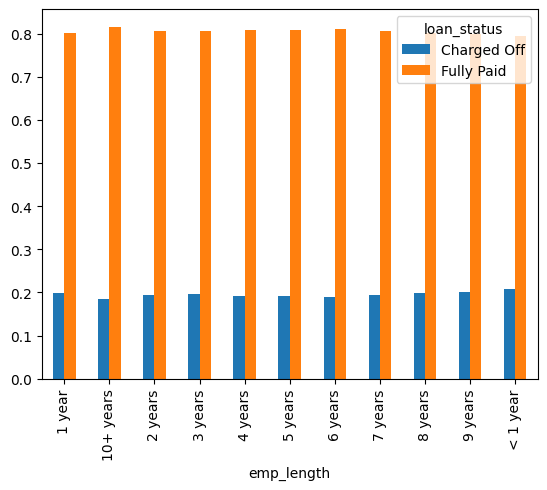

In [24]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


### Verification Status

In [25]:
(pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index", margins = True)*100).round(2)

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,14.64,85.36
Source Verified,21.47,78.53
Verified,22.32,77.68
All,19.61,80.39


In [26]:
(pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "all", margins = True)*100).round(2)

loan_status,Charged Off,Fully Paid,All
verification_status,,,
Not Verified,4.62,26.96,31.58
Source Verified,7.12,26.05,33.18
Verified,7.87,27.37,35.24
All,19.61,80.39,100.00


### Purpose

In [27]:
result_purposeLoan =pd.crosstab(index = df["purpose"],
                               columns= df["loan_status"],normalize= "index", margins = True)*100
result_purposeLoan.round(2)

loan_status,Charged Off,Fully Paid
purpose,,
car,13.48,86.52
credit_card,16.71,83.29
debt_consolidation,20.74,79.26
educational,16.34,83.66
home_improvement,17.01,82.99
house,19.72,80.28
major_purchase,16.47,83.53
medical,21.71,78.29
moving,23.48,76.52


In [28]:
(pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "all", margins = True, margins_name='All')*100).round(2).sort_values(by='All', axis=0, ascending=False)

loan_status,Charged Off,Fully Paid,All
purpose,,,
All,19.61,80.39,100.00
debt_consolidation,12.28,46.93,59.21
credit_card,3.50,17.46,20.96
home_improvement,1.03,5.04,6.07
other,1.14,4.21,5.35
major_purchase,0.37,1.85,2.22
small_business,0.42,1.02,1.44
car,0.16,1.03,1.19
medical,0.23,0.83,1.06


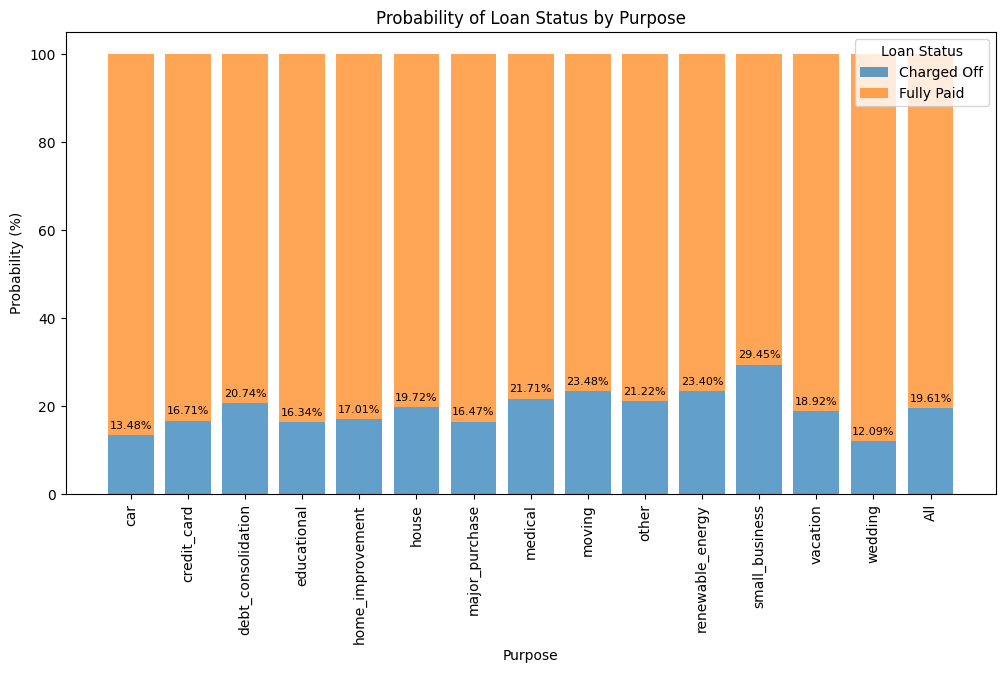

In [29]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_purposeLoan["Charged Off"]
fully_paid_prob = result_purposeLoan["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_purposeLoan.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_purposeLoan.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by Purpose")
plt.xlabel("Purpose")
plt.ylabel("Probability (%)")
plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()


### Public Rec Bankruptcies

In [30]:
(pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "all", margins = True, margins_name='All')*100).round(2).sort_values(by='All', axis=0, ascending=False)

loan_status,Charged Off,Fully Paid,All
pub_rec_bankruptcies,,,
All,19.62,80.38,100.00
0.0,17.27,71.32,88.59
1.0,2.21,8.61,10.82
2.0,0.11,0.36,0.47
3.0,0.02,0.07,0.09
4.0,0.01,0.01,0.02
5.0,0.00,0.01,0.01
6.0,0.00,0.00,0.00
7.0,0.00,0.00,0.00


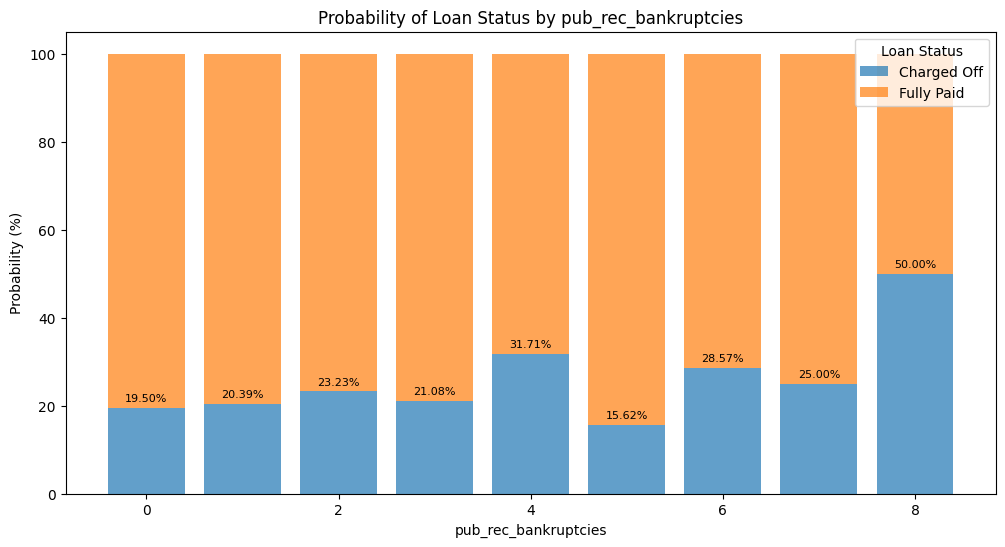

In [31]:
result_pub_rec_bankruptcies = (pd.crosstab(index=df["pub_rec_bankruptcies"], columns=df["loan_status"], normalize="index") * 100).round(2)

# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_pub_rec_bankruptcies["Charged Off"]
fully_paid_prob = result_pub_rec_bankruptcies["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_pub_rec_bankruptcies.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_pub_rec_bankruptcies.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by pub_rec_bankruptcies")
plt.xlabel("pub_rec_bankruptcies")
plt.ylabel("Probability (%)")
# plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()

### Address

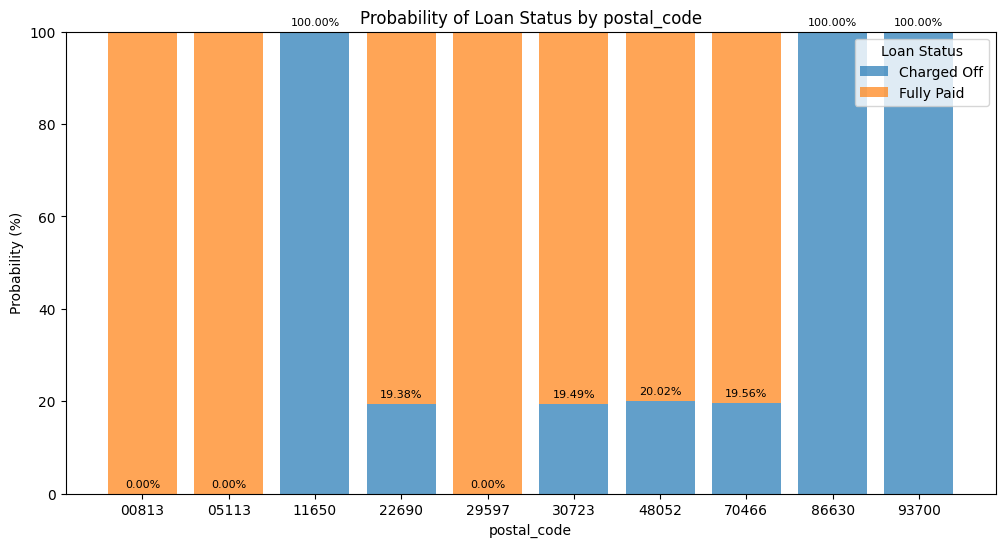

In [32]:
result_postal_code = (pd.crosstab(index=df["postal_code"], columns=df["loan_status"], normalize="index") * 100).round(2)

# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_postal_code["Charged Off"]
fully_paid_prob = result_postal_code["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_postal_code.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_postal_code.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by postal_code")
plt.xlabel("postal_code")
plt.ylabel("Probability (%)")
# plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()

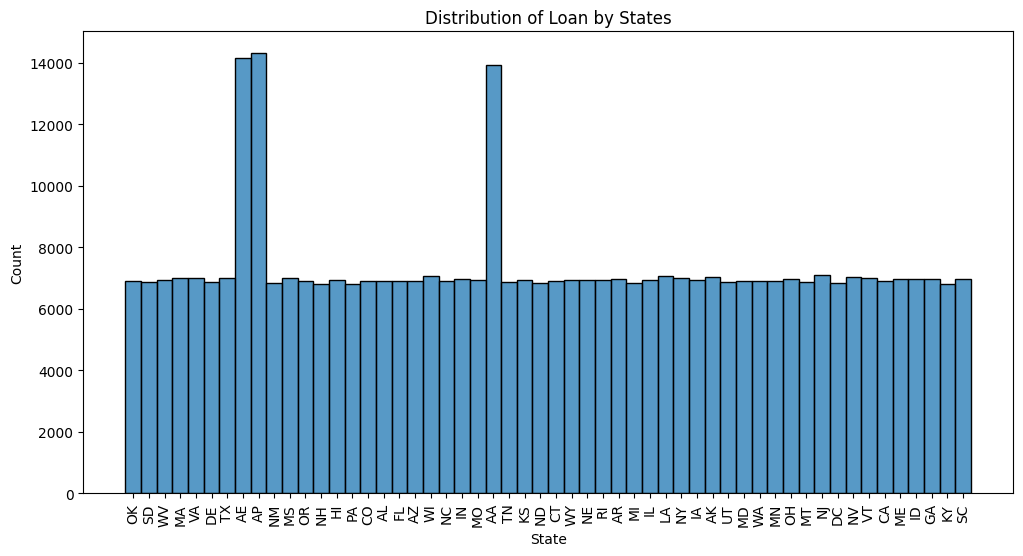

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(df["State"])
plt.title("Distribution of Loan by States")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

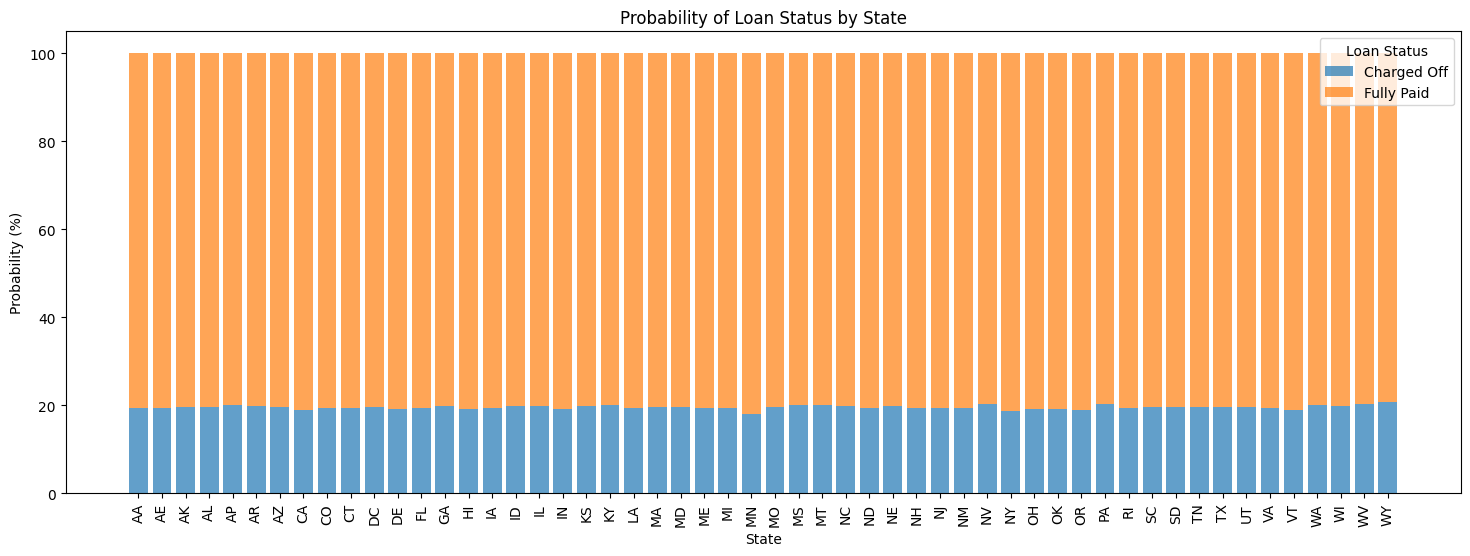

In [34]:
result_state = (pd.crosstab(index=df["State"], columns=df["loan_status"], normalize="index") * 100).round(2)

# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_state["Charged Off"]
fully_paid_prob = result_state["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(18, 6))
bars_charged_off = plt.bar(result_state.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label

plt.bar(result_state.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by State")
plt.xlabel("State")
plt.ylabel("Probability (%)")
plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()

### Debt To Income

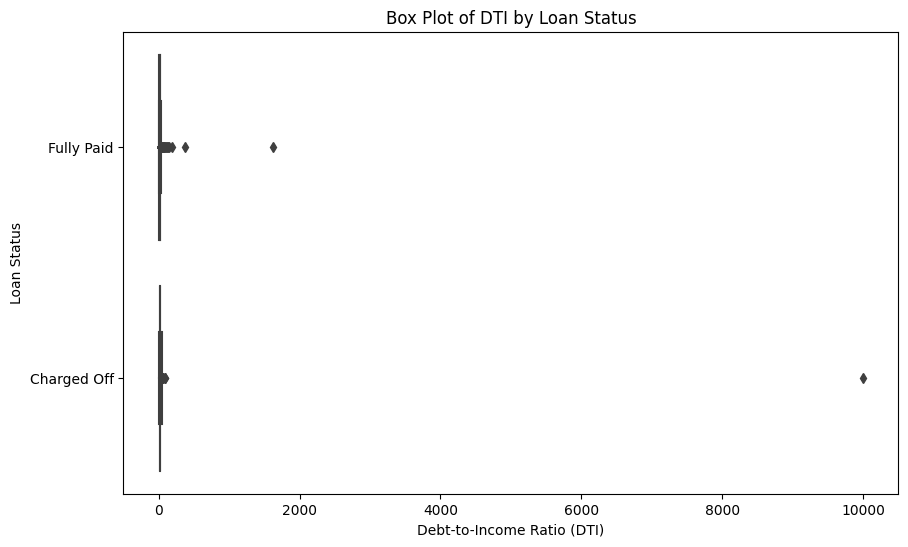

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df["loan_status"], x=df["dti"])
plt.title("Box Plot of DTI by Loan Status")
plt.ylabel("Loan Status")
plt.xlabel("Debt-to-Income Ratio (DTI)")
plt.show()

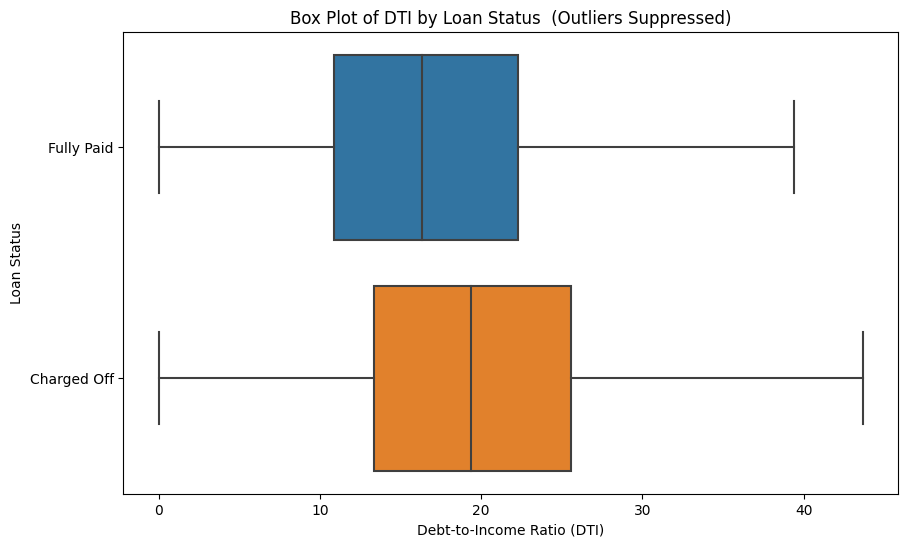

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df["loan_status"], x=df["dti"], showfliers=False)
plt.title("Box Plot of DTI by Loan Status  (Outliers Suppressed)")
plt.ylabel("Loan Status")
plt.xlabel("Debt-to-Income Ratio (DTI)")
plt.show()

In [37]:
# Home Ownership
# Annual Income
# Credit Line
# Revol balance
# Revol Utilisation
# Total Acc
# Initial List Status
# Application Type

### Mortgage accounts

<ipython-input-38-afc23c0a59b2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='spearman')


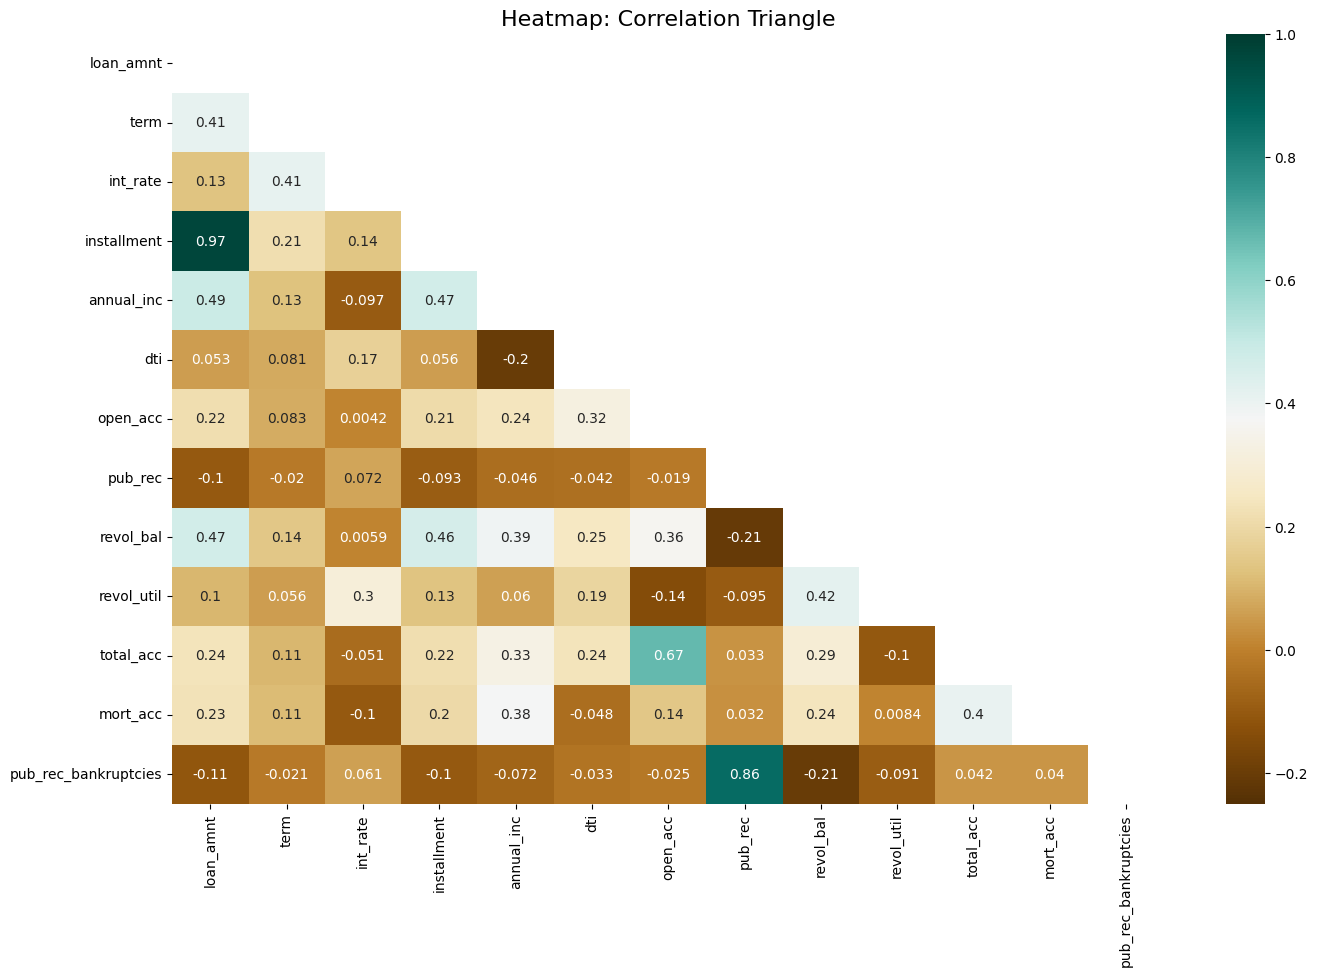

In [38]:
corr = df.corr(method='spearman')
plt.figure(figsize=((16,10)))
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
heatmap = sns.heatmap(corr, mask=mask, vmin=-.25, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Heatmap: Correlation Triangle',fontdict={'fontsize':16})
plt.show()

## Data Pre Processing

In [39]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'postal_code', 'State', 'City'],
      dtype='object')

In [40]:
# Drop rows with missing values
# df.dropna(inplace=True)
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy="most_frequent")
df["mort_acc"] = Imputer.fit_transform(df["mort_acc"].values.reshape(-1,1))
df["emp_title"] = Imputer.fit_transform(df["emp_title"].values.reshape(-1,1))
df["emp_length"] = Imputer.fit_transform(df["emp_length"].values.reshape(-1,1))

df.drop(["title","issue_d","earliest_cr_line","initial_list_status"],axis = 1, inplace=True)

In [41]:
### Target Encoding

In [42]:
pip install category_encoders

In [43]:
from category_encoders import TargetEncoder

In [44]:
df["loan_status"].replace({"Fully Paid":0,
                          "Charged Off" : 1},inplace=True)

In [45]:
cat_cols=df.dtypes=="object"
cat_cols= list(cat_cols[cat_cols].index)
cat_cols

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'postal_code',
 'State',
 'City']

In [46]:
TE = TargetEncoder()
df[cat_cols] = TE.fit_transform(df[cat_cols],df["loan_status"])

In [47]:
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,postal_code,State,City
0,10000.0,36,11.44,329.48,0.125730,0.138393,0.247140,0.195737,0.226622,117000.0,0.146360,0,0.189233,26.24,16.0,0.0,36369.0,41.8,25.0,0.196087,0.0,0.0,0.193784,0.192013,0.186995
1,8000.0,36,11.99,265.68,0.125730,0.155037,0.217322,0.192385,0.169561,65000.0,0.146360,0,0.207414,22.05,17.0,0.0,20131.0,53.3,27.0,0.196087,3.0,0.0,0.000000,0.197038,0.237829
2,15600.0,36,10.49,506.97,0.125730,0.123354,0.191993,0.206872,0.226622,43057.0,0.214743,0,0.167118,12.79,13.0,0.0,11987.0,92.2,26.0,0.196087,0.0,0.0,0.000000,0.204061,0.191921
3,7200.0,36,6.49,220.65,0.062879,0.048186,0.170611,0.189194,0.226622,54000.0,0.146360,0,0.167118,2.60,6.0,0.0,5472.0,21.5,13.0,0.196087,0.0,0.0,0.000000,0.196098,0.165834
4,24375.0,60,17.27,609.33,0.211809,0.245067,0.300719,0.200470,0.169561,55000.0,0.223211,1,0.167118,33.95,13.0,0.0,24584.0,69.8,43.0,0.196087,1.0,0.0,1.000000,0.195101,0.239233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,217.38,0.125730,0.138393,0.170611,0.193262,0.226622,40000.0,0.214743,0,0.207414,15.63,6.0,0.0,1990.0,34.3,23.0,0.196087,0.0,0.0,0.194903,0.195557,0.191993
396026,21000.0,36,12.29,700.42,0.211809,0.173696,0.220430,0.192187,0.169561,110000.0,0.214743,0,0.207414,21.45,6.0,0.0,43263.0,95.7,8.0,0.196087,1.0,0.0,0.000000,0.193690,0.186965
396027,5000.0,36,9.99,161.32,0.125730,0.098582,0.268003,0.195737,0.226622,56500.0,0.223211,0,0.207414,17.56,15.0,0.0,32704.0,66.9,23.0,0.196087,0.0,0.0,0.195630,0.186465,0.197591
396028,21000.0,60,15.31,503.02,0.211809,0.197520,0.170611,0.195737,0.169561,64000.0,0.223211,0,0.207414,15.88,9.0,0.0,15704.0,53.8,20.0,0.196087,5.0,0.0,0.000000,0.193469,0.194118


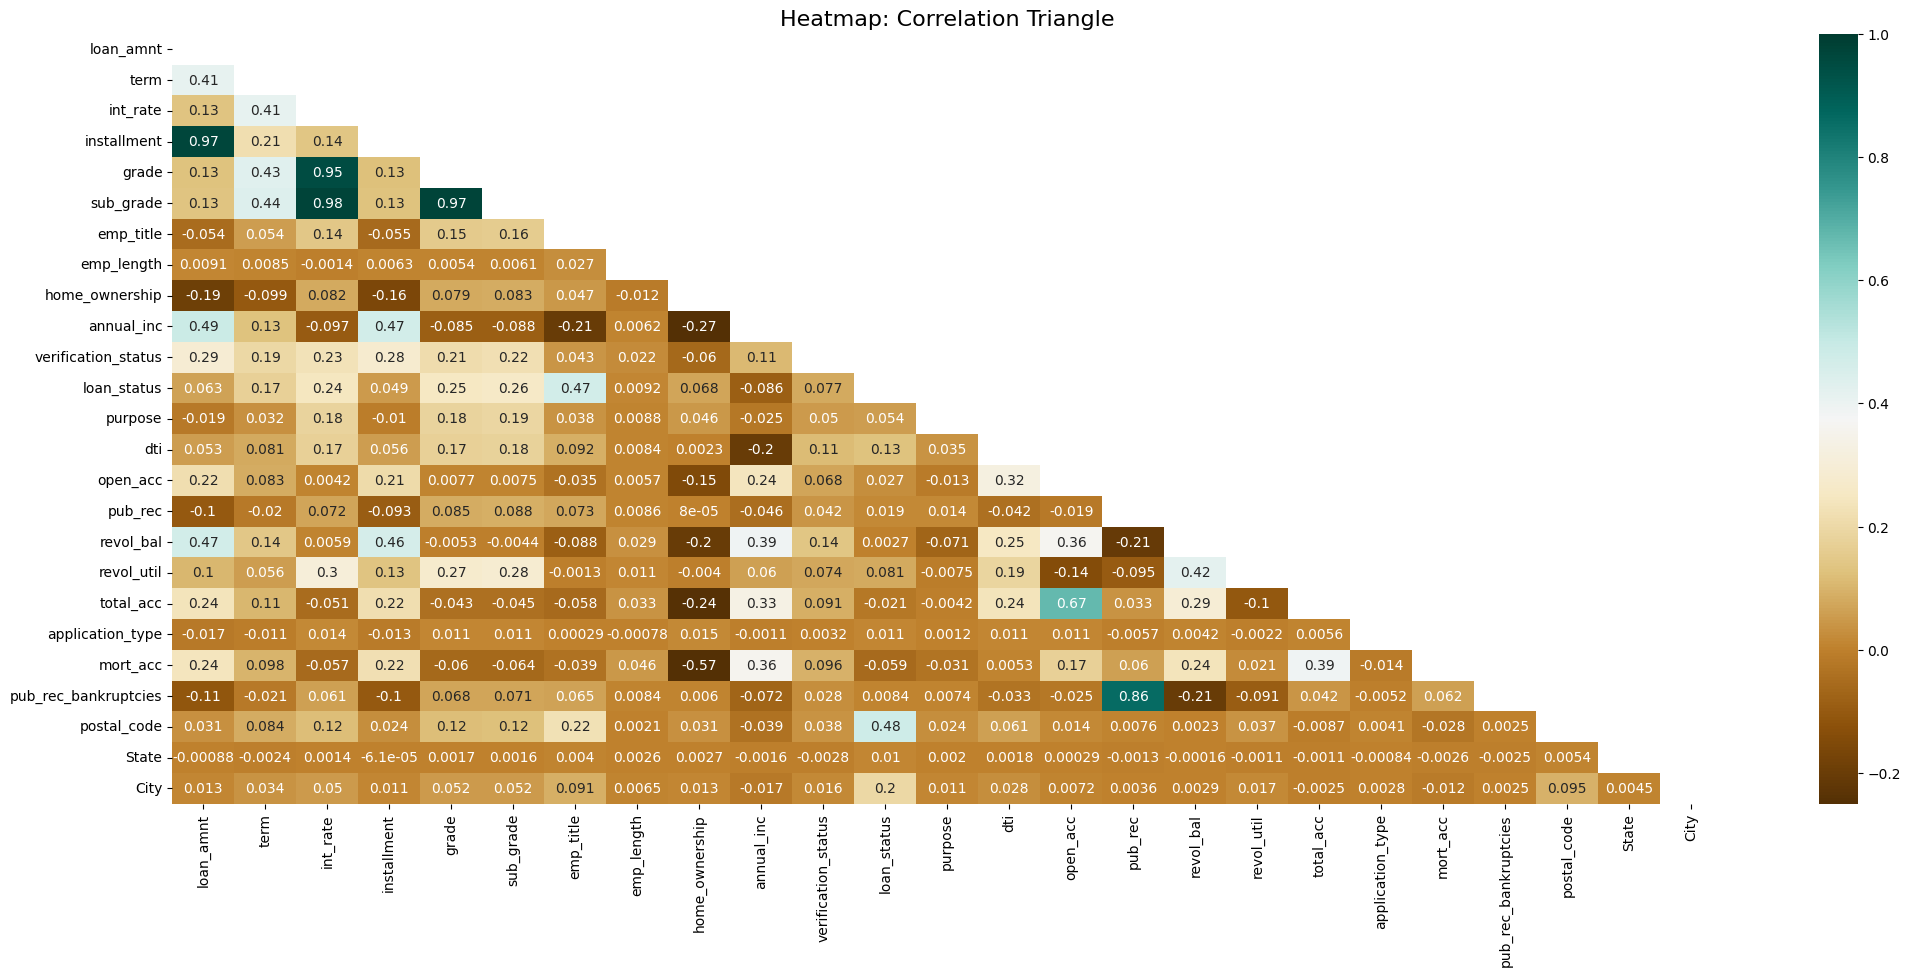

In [48]:
corr = df.corr(method='spearman')
plt.figure(figsize=((25,10)))
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
heatmap = sns.heatmap(corr, mask=mask, vmin=-.25, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Heatmap: Correlation Triangle',fontdict={'fontsize':16})
plt.show()

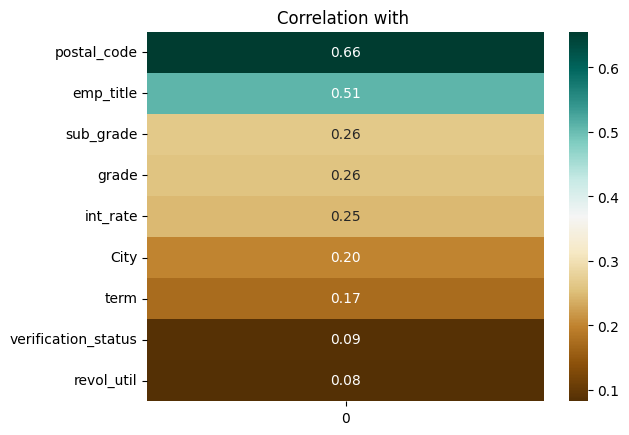

In [49]:
corr_matrix = df.corrwith(df['loan_status'])
sorted_corr_matrix = corr_matrix.abs().sort_values(ascending=False)
sorted_corr_matrix =sorted_corr_matrix.iloc[1:10]
sns.heatmap(sorted_corr_matrix.to_frame(), cmap="BrBG", annot=True, fmt=".2f")
plt.title("Correlation with ")
plt.show()

In [50]:
find_missing_values(df,False)

,Column,Count,Percentage
1,pub_rec_bankruptcies,535,0.14
0,revol_util,276,0.07


In [51]:
df.dropna(inplace=True)

In [52]:
X = df.drop(["loan_status"],axis = 1)
y = df["loan_status"]

In [53]:
from sklearn.model_selection import train_test_split

X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25,random_state=1)
X_train.shape

(237131, 24)

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

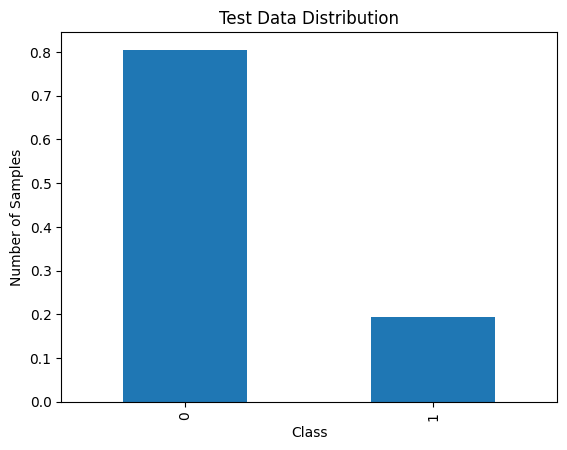

In [55]:
y_test.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight={0:1,1:4})
model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 4})

In [60]:
print('Model Accuracy Train:',model.score(X_train,y_train).round(3))
print('Model Accuracy Val:',model.score(X_val,y_val).round(3))
print('Model Accuracy Test:',model.score(X_test,y_test).round(3))

Model Accuracy Train: 0.895
Model Accuracy Val: 0.895
Model Accuracy Test: 0.894


In [61]:
from sklearn.metrics import f1_score,recall_score,precision_score

In [62]:
y_pred =model.predict(X_test)
f1_score(y_test,y_pred).round(2)

0.76

In [63]:
(pd.DataFrame(data=model.coef_,columns=X.columns).T).round(3).sort_values(by=0, axis=0, ascending=False)

,0
postal_code,10.378
emp_title,1.395
sub_grade,0.576
City,0.507
dti,0.442
term,0.235
open_acc,0.172
revol_util,0.156
home_ownership,0.144
installment,0.065


In [64]:

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,precision_recall_curve
)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[57093,  6539],
       [ 1820, 13592]])

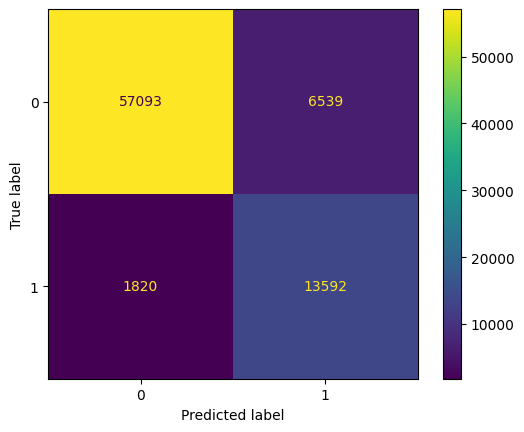

In [65]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [66]:
np.diag(conf_matrix).sum() / conf_matrix.sum()

0.8942487728353828

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     63632
           1       0.68      0.88      0.76     15412

    accuracy                           0.89     79044
   macro avg       0.82      0.89      0.85     79044
weighted avg       0.91      0.89      0.90     79044



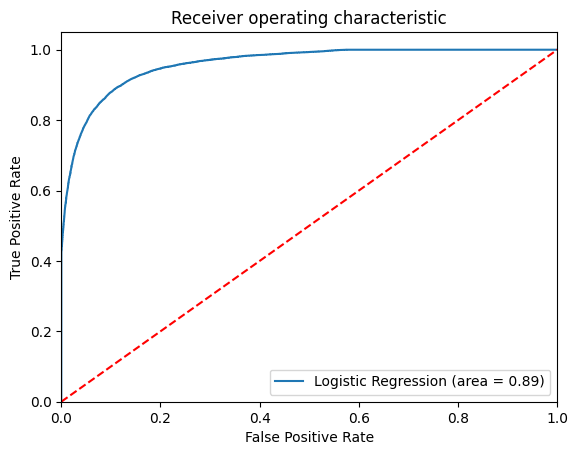

In [68]:
logit_roc_auc=roc_auc_score(y_test,model.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

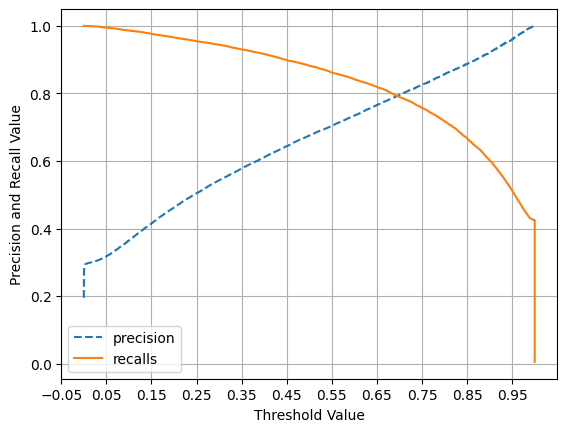

In [69]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')

    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,model.predict_proba(X_test)[:,1])

In [70]:
probability = model.predict_proba(X_test)
probability

array([[9.99819432e-01, 1.80568032e-04],
       [7.86319797e-01, 2.13680203e-01],
       [2.22885831e-01, 7.77114169e-01],
       ...,
       [8.10308434e-01, 1.89691566e-01],
       [8.78600280e-01, 1.21399720e-01],
       [7.62937956e-01, 2.37062044e-01]])

In [71]:
probabilites = probability[:,1]

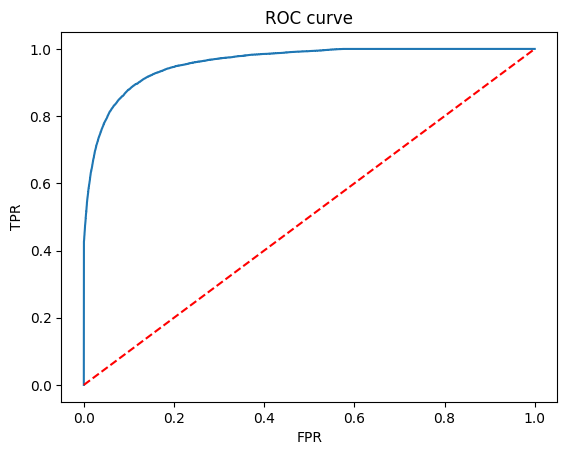

In [72]:
fpr, tpr, thr = roc_curve(y_test,probabilites)
plt.plot(fpr,tpr)

#random model
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [73]:
precision, recall, thr = precision_recall_curve(y_test, probabilites)

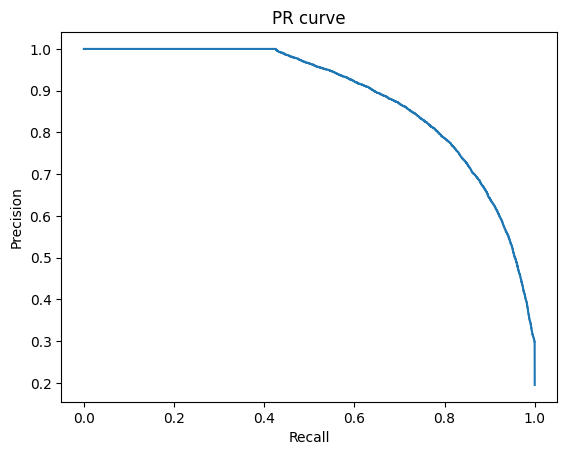

In [74]:
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show()